In [151]:
# IMPORTING NECESSARY LIBRARIES.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold,train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import time
from sklearn.metrics import mean_squared_log_error
pd.set_option('display.max_rows', 500)

In [152]:
# IMPORTING DATA
train = pd.read_csv(r"C:\Users\kulka\Desktop\AV_Hackathon_Codes\Jobathon_Sep\Data\TRAIN (1).csv",parse_dates=['Date'])
test  = pd.read_csv(r"C:\Users\kulka\Desktop\AV_Hackathon_Codes\Jobathon_Sep\Data\TEST_FINAL.csv",parse_dates=['Date'])

In [153]:
# SUBMISSION FILE
Submission = test[['ID']]

In [154]:
# BASIC INFORMATION ABOUT THE TWO DATASETS
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ID             188340 non-null  object        
 1   Store_id       188340 non-null  int64         
 2   Store_Type     188340 non-null  object        
 3   Location_Type  188340 non-null  object        
 4   Region_Code    188340 non-null  object        
 5   Date           188340 non-null  datetime64[ns]
 6   Holiday        188340 non-null  int64         
 7   Discount       188340 non-null  object        
 8   #Order         188340 non-null  int64         
 9   Sales          188340 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 14.4+ MB


In [155]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22265 entries, 0 to 22264
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ID             22265 non-null  object        
 1   Store_id       22265 non-null  int64         
 2   Store_Type     22265 non-null  object        
 3   Location_Type  22265 non-null  object        
 4   Region_Code    22265 non-null  object        
 5   Date           22265 non-null  datetime64[ns]
 6   Holiday        22265 non-null  int64         
 7   Discount       22265 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 1.4+ MB


Few Observations about the two datasets,

1. No missing values in either train or test datasets.
2. Date column in both dataframes is of datetime data type.
3. #Order column from the training dataset is missing from the testing dataset because we will not know the number of orders we get in the future.
4. 5 columns are of object data type, 3 are integer types, 1 float and 1 datetime data type.
5. Sales is the dependent variable. 
6. Train Dataset is from 1st Jan 2018 to 31st May 2019 (1.5 Years of data).
7. Test dataset is from 1st June 2019 to 31st July 2019 (2 months of data).

In [156]:
# CHECKING THE TOP AND BOTTOM 5 ROWS OF TRAIN DATASET.
train.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


In [157]:
train.tail()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
188335,T1188336,149,S2,L3,R2,2019-05-31,1,Yes,51,37272.00
188336,T1188337,153,S4,L2,R1,2019-05-31,1,No,90,54572.64
188337,T1188338,154,S1,L3,R2,2019-05-31,1,No,56,31624.56
188338,T1188339,155,S3,L1,R2,2019-05-31,1,Yes,70,49162.41
188339,T1188340,152,S2,L1,R1,2019-05-31,1,No,47,37977.00


In [158]:
# CHECKING THE TOP AND BOTTOM 5 ROWS OF TEST DATASET.
test.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount
0,T1188341,171,S4,L2,R3,2019-06-01,0,No
1,T1188342,172,S1,L1,R1,2019-06-01,0,No
2,T1188343,173,S4,L2,R1,2019-06-01,0,No
3,T1188344,174,S1,L1,R4,2019-06-01,0,No
4,T1188345,170,S1,L1,R2,2019-06-01,0,No


In [159]:
test.tail()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount
22260,T1210601,186,S2,L5,R2,2019-07-31,0,No
22261,T1210602,11,S4,L2,R1,2019-07-31,0,No
22262,T1210603,185,S1,L1,R3,2019-07-31,0,Yes
22263,T1210604,69,S1,L1,R4,2019-07-31,0,No
22264,T1210605,365,S2,L1,R2,2019-07-31,0,No


### EDA (Univariate Analysis)

#### Store_id

In [160]:
train['Store_id'].nunique(), test['Store_id'].nunique()

(365, 365)

In [161]:
print (set(train['Store_id'].values)-set(test['Store_id'].values))

set()


In [162]:
train['Store_id'].value_counts(dropna=False).sort_index()

1      516
2      516
3      516
4      516
5      516
6      516
7      516
8      516
9      516
10     516
11     516
12     516
13     516
14     516
15     516
16     516
17     516
18     516
19     516
20     516
21     516
22     516
23     516
24     516
25     516
26     516
27     516
28     516
29     516
30     516
31     516
32     516
33     516
34     516
35     516
36     516
37     516
38     516
39     516
40     516
41     516
42     516
43     516
44     516
45     516
46     516
47     516
48     516
49     516
50     516
51     516
52     516
53     516
54     516
55     516
56     516
57     516
58     516
59     516
60     516
61     516
62     516
63     516
64     516
65     516
66     516
67     516
68     516
69     516
70     516
71     516
72     516
73     516
74     516
75     516
76     516
77     516
78     516
79     516
80     516
81     516
82     516
83     516
84     516
85     516
86     516
87     516
88     516
89     516
90     516
91     516

1. There are 365 unique store id's as stated in the problem statement.
2. All 365 Store_id values present in Training Data are also present in the testing dataset.
3. Each store occurs 516 times in the training dataset (which is expected as the data is for 1.5 years).

#### Store_Type

In [163]:
train['Store_Type'].nunique(), test['Store_Type'].nunique()

(4, 4)

In [164]:
print (set(train['Store_Type'].values)-set(test['Store_Type'].values))

set()


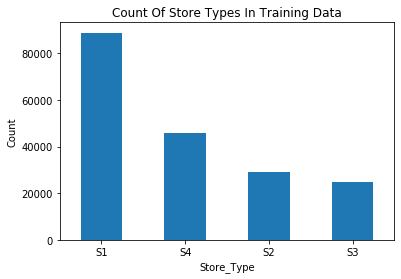

In [165]:
train['Store_Type'].value_counts(dropna=False).plot(kind='bar');
plt.title("Count Of Store Types In Training Data");
plt.xlabel("Store_Type");
plt.ylabel("Count");
plt.xticks(rotation=360);

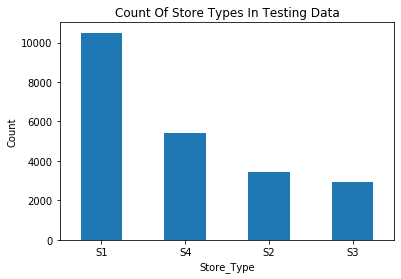

In [166]:
test['Store_Type'].value_counts(dropna=False).plot(kind='bar');
plt.title("Count Of Store Types In Testing Data");
plt.xlabel("Store_Type");
plt.ylabel("Count");
plt.xticks(rotation=360);

Few observations about Store_Type variable,

1. There are 4 unique types of stores. 
2. Store_Type S1 seems to be the most popular in both training and testing datasets and S3 is the least popular.
3. All the Store_Types in training data are present in the testing dataset as well.

#### Location_Type

In [167]:
train['Location_Type'].nunique(), test['Location_Type'].nunique()

(5, 5)

In [168]:
print (set(train['Location_Type'].values)-set(test['Location_Type'].values))

set()


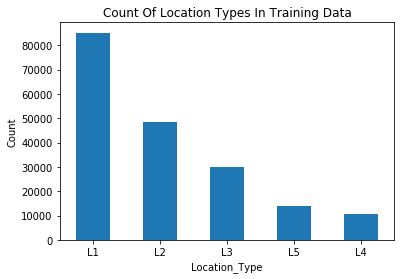

In [169]:
train['Location_Type'].value_counts(dropna=False).plot(kind='bar');
plt.title("Count Of Location Types In Training Data");
plt.xlabel("Location_Type");
plt.ylabel("Count");
plt.xticks(rotation=360);

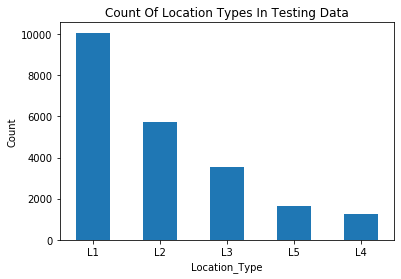

In [170]:
test['Location_Type'].value_counts(dropna=False).plot(kind='bar');
plt.title("Count Of Location Types In Testing Data");
plt.xlabel("Location_Type");
plt.ylabel("Count");
plt.xticks(rotation=360);

Few observations about Location_Type variable,

1. There are 5 unique types of Locations. 
2. Location_Type L1 seems to be the most popular in both training and testing datasets and L4 is the least popular.
3. All the Location_Types in training data are present in the testing dataset as well.

#### Region_Code

In [171]:
train['Region_Code'].nunique(), test['Region_Code'].nunique()

(4, 4)

In [172]:
print (set(train['Region_Code'].values)-set(test['Region_Code'].values))

set()


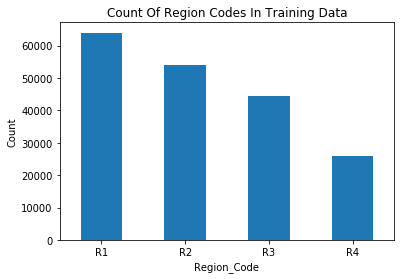

In [173]:
train['Region_Code'].value_counts(dropna=False).plot(kind='bar');
plt.title("Count Of Region Codes In Training Data");
plt.xlabel("Region_Code");
plt.ylabel("Count");
plt.xticks(rotation=360);

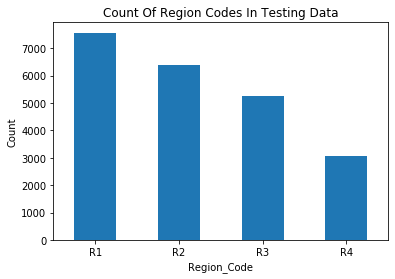

In [174]:
test['Region_Code'].value_counts(dropna=False).plot(kind='bar');
plt.title("Count Of Region Codes In Testing Data");
plt.xlabel("Region_Code");
plt.ylabel("Count");
plt.xticks(rotation=360);

Few observations about Region_Code variable,

1. There are 4 unique types of Regions. 
2. Region_Code R1 seems to be the most popular in both training and testing datasets and R4 is the least popular.
3. All the Region_Codes in training data are present in the testing dataset as well.

#### Holiday

In [175]:
train[train['Holiday']==1]['Date'].nunique(),test[test['Holiday']==1]['Date'].nunique()

(68, 2)

Train data totally has 68 holidays whereas the test data has 2 holidays.

#### Discount

In [176]:
train[train['Discount']=="Yes"]['Date'].nunique(), test[test['Discount']=="Yes"]['Date'].nunique()

(501, 61)

There were 501 days in training data on which there was some discount provided by the store.

There were 61 days in testing data on which there was some discount provided by the store.

#### Sales

In [177]:
train['Sales'].describe()

count    188340.000000
mean      42784.327982
std       18456.708302
min           0.000000
25%       30426.000000
50%       39678.000000
75%       51909.000000
max      247215.000000
Name: Sales, dtype: float64

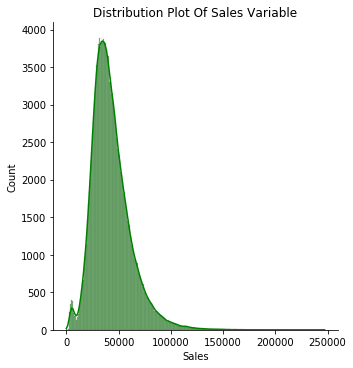

In [178]:
sns.displot(train['Sales'],color='green',kde=True);
plt.title("Distribution Plot Of Sales Variable");

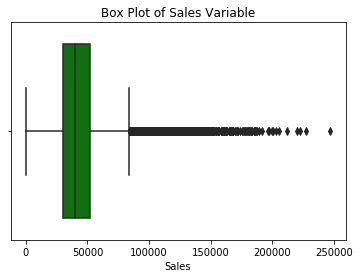

In [179]:
sns.boxplot(train['Sales'],color='green');
plt.title("Box Plot of Sales Variable");

Few observations about the sales variable,

1. Boxplot shows that there are some outliers, not many.
2. The distribution plot shows that the distribution is almost normal (although we see a skew towards right), we can see it from the skewness value below.
3. Minimum Sales value of 0 sould be explored further.
4. As we can see below, there are 19 rows in the train data where the sales is 0. The reason may be because the store wasn't open that day, it can be seen from the 0 orders received on that particular day.

In [180]:
print (f"There are {len(train[train['Sales']==0])} rows in the Training Data where the sales value is 0")

There are 19 rows in the Training Data where the sales value is 0


In [181]:
# ROWS WHERE THE SALES IS 0 
train[train['Sales']==0]

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
23867,T1023868,311,S4,L2,R2,2018-03-07,0,No,0,0.0
38143,T1038144,222,S4,L2,R2,2018-04-15,1,No,0,0.0
90458,T1090459,233,S1,L3,R3,2018-09-05,0,No,0,0.0
97301,T1097302,271,S1,L3,R2,2018-09-24,0,No,0,0.0
97480,T1097481,271,S1,L3,R2,2018-09-25,0,No,0,0.0
99489,T1099490,12,S1,L3,R2,2018-09-30,0,No,0,0.0
99904,T1099905,12,S1,L3,R2,2018-10-01,0,No,0,0.0
100215,T1100216,12,S1,L3,R2,2018-10-02,1,No,0,0.0
112564,T1112565,39,S4,L1,R1,2018-11-05,0,No,0,0.0
112853,T1112854,39,S4,L1,R1,2018-11-06,1,No,0,0.0


In [182]:
print (f"Skewness of the Sales Variable is : {train['Sales'].skew()}")

Skewness of the Sales Variable is : 1.248819154338717


In [183]:
# IDENTIFYING OUTLIERS IN THE SALES DATA
Q1 = train['Sales'].quantile(0.25)
Q3 = train['Sales'].quantile(0.75)
IQR = Q3 - Q1
print (f"Sales below {Q1-1.5*IQR} and above {Q3+1.5*IQR} can be considered as outliers.")

Sales below -1798.5 and above 84133.5 can be considered as outliers.


In [184]:
train[(train['Sales']<(Q1-1.5*IQR))|(train['Sales']>(Q3+1.5*IQR))]

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
77,T1000078,223,S2,L5,R2,2018-01-01,1,Yes,118,85426.92
133,T1000134,316,S4,L2,R1,2018-01-01,1,Yes,132,86962.68
180,T1000181,86,S1,L1,R4,2018-01-01,1,Yes,154,115665.30
187,T1000188,88,S2,L5,R2,2018-01-01,1,Yes,90,86203.20
306,T1000307,176,S4,L2,R3,2018-01-01,1,Yes,180,126633.00
...,...,...,...,...,...,...,...,...,...,...
188243,T1188244,173,S4,L2,R1,2019-05-31,1,No,132,90231.54
188299,T1188300,131,S4,L2,R1,2019-05-31,1,No,151,95497.92
188320,T1188321,337,S4,L2,R1,2019-05-31,1,No,171,110414.28
188321,T1188322,160,S4,L2,R1,2019-05-31,1,Yes,152,87785.70


As we can see above, there are 5843 records in the dataset that can be considered as outliers. 

#### Orders

In [185]:
train['#Order'].describe()

count    188340.000000
mean         68.205692
std          30.467415
min           0.000000
25%          48.000000
50%          63.000000
75%          82.000000
max         371.000000
Name: #Order, dtype: float64

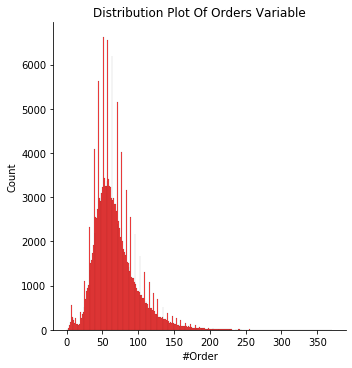

In [186]:
sns.displot(train['#Order'],color='red');
plt.title("Distribution Plot Of Orders Variable");

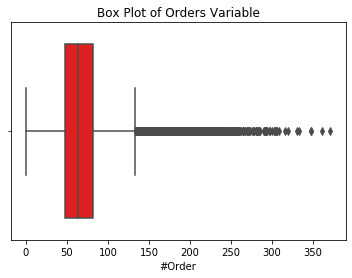

In [187]:
sns.boxplot(train['#Order'],color='red');
plt.title("Box Plot of Orders Variable");

Few observations about the Orders variable,

1. Boxplot shows that there are some outliers, not many.
2. The distribution plot shows that the distribution is almost normal (although we see a skew towards right), we can see it from the skewness value below.
3. Minimum number of orders value of 0 sould be explored further.
4. As we can see below, there are 19 rows in the train data where the orders and sales is 0. The reason may be because the store wasn't open that day.

In [188]:
print (f"Skewness of the Orders Variable is : {train['#Order'].skew()}")

Skewness of the Orders Variable is : 1.3728735099625982


In [189]:
train[(train['#Order']==0) & (train['Sales']==0)]

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
23867,T1023868,311,S4,L2,R2,2018-03-07,0,No,0,0.0
38143,T1038144,222,S4,L2,R2,2018-04-15,1,No,0,0.0
90458,T1090459,233,S1,L3,R3,2018-09-05,0,No,0,0.0
97301,T1097302,271,S1,L3,R2,2018-09-24,0,No,0,0.0
97480,T1097481,271,S1,L3,R2,2018-09-25,0,No,0,0.0
99489,T1099490,12,S1,L3,R2,2018-09-30,0,No,0,0.0
99904,T1099905,12,S1,L3,R2,2018-10-01,0,No,0,0.0
100215,T1100216,12,S1,L3,R2,2018-10-02,1,No,0,0.0
112564,T1112565,39,S4,L1,R1,2018-11-05,0,No,0,0.0
112853,T1112854,39,S4,L1,R1,2018-11-06,1,No,0,0.0


### EDA (Bi-Variate Analysis)

In [190]:
# LET'S CHECK HOW MANY STORE_ID'S ARE IN EACH STORE_TYPE
train.groupby('Store_Type')['Store_id'].nunique()

Store_Type
S1    172
S2     56
S3     48
S4     89
Name: Store_id, dtype: int64

In [191]:
# LET'S CHECK HOW MANY STORE_ID'S ARE IN EACH LOCATION_TYPE
train.groupby('Location_Type')['Store_id'].nunique()

Location_Type
L1    165
L2     94
L3     58
L4     21
L5     27
Name: Store_id, dtype: int64

In [192]:
# LET'S CHECK HOW MANY STORE_ID'S ARE IN EACH REGION_CODE
train.groupby('Region_Code')['Store_id'].nunique()

Region_Code
R1    124
R2    105
R3     86
R4     50
Name: Store_id, dtype: int64

In [193]:
# LET'S CHECK THE SALES BY STORE_TYPES
train.groupby('Store_Type')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
Store_Type,,,,,,,,
S1,88752.0,37676.511694,12303.151090,0.00,29859.0,36444.0,44439.00,143841.0
S2,28896.0,27530.828222,9168.839395,1748.28,21666.0,26794.5,32703.90,96363.0
S3,24768.0,47063.068209,14907.465521,0.00,37656.0,45445.5,55062.75,166323.0
S4,45924.0,59945.685926,20750.228035,0.00,46503.0,57075.0,70326.75,247215.0


We can observe from the above table that,

1. Mean Sales of Store_Type S2 is the lowest and sales of S2 is the highest.
2. Min Sales of Store_Types S1, S3 and S4 are all 0 except S2.
3. Maximum sales comes from Store_Type S4. 

In [194]:
# LET'S CHECK THE SALES BY LOCATION_TYPE
train.groupby("Location_Type")['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
Location_Type,,,,,,,,
L1,85140.0,41453.597889,13520.616642,0.00,32598.00,39831.000,48702.000,144789.0
L2,48504.0,59231.480373,20642.975708,0.00,45731.25,56235.975,69555.000,247215.0
L3,29928.0,33072.257756,10720.509117,0.00,26119.98,31987.200,39084.000,117495.0
L4,10836.0,29067.414313,9176.431608,1969.14,23075.25,28554.000,34413.750,91677.0
L5,13932.0,25187.787261,8990.099353,1748.28,19416.00,24528.000,30395.235,86203.2


We can observe from the above table that,

1. Mean Sales of Location_Type L5 is the lowest and sales of L2 is the highest.
2. Min Sales of Location_Types L1, L2 and L3 are all 0 except L4 and L5.
3. Maximum sales comes from Store_Type L2.

In [195]:
# LET'S CHECK THE SALES BY REGION_CODE
train.groupby('Region_Code')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
Region_Code,,,,,,,,
R1,63984.0,46765.488405,21286.095441,0.0,32091.00,43125.0,57624.00,247215.0
R2,54180.0,40054.847344,16468.619529,0.0,29078.25,37548.0,48357.00,192156.0
R3,44376.0,42144.517063,16615.730308,0.0,30876.00,39661.5,50970.75,227127.0
R4,25800.0,39743.434249,15930.494396,2009.7,29195.64,37474.5,47796.00,161271.0


We can observe from the above table that,

1. Mean Sales of Region_Code R4 is the lowest and sales of R1 is the highest.
2. Min Sales of Region_Code R1, R2 and R3 are all 0 except R4.
3. Maximum sales comes from Region_Code R1.

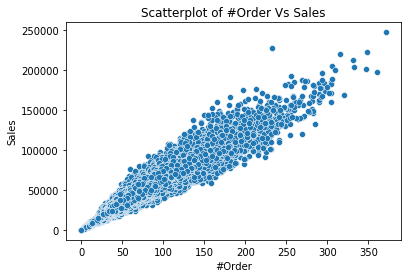

In [196]:
# LET'S CHECK IF THERE IS A RELATIONSHIP BETWEEN #ORDERS AND SALES
sns.scatterplot(x=train['#Order'],y=train['Sales']);
plt.title("Scatterplot of #Order Vs Sales");

We can see from the above scatterplot that as the number of orders increase, the sales increases too. The relationship is clearly linear in nature. 

In [197]:
# LET'S CHECK IF THE HOLIDAY HAS ANY AFFECT ON THE SALES.
train.groupby('Holiday')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
Holiday,,,,,,,,
0,163520.0,43897.288998,18143.426019,0.0,31389.00,40530.00,52761.000,247215.00
1,24820.0,35451.878930,18822.332593,0.0,23778.57,33417.54,45247.125,197840.61


We can observe from the table above that the mean sales was lower when there was a holiday. This might be attributed to the fact that there are fewer holidas in a year. We can also see that the maximum sales were recorded when there was no holiday.

In [198]:
# LET'S CHECK IF THE DISCOUNTS HAS ANY AFFECT ON THE SALES.
train.groupby('Discount')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
Discount,,,,,,,,
No,104051.0,37403.679678,16039.555183,0.00,27069.00,34791.0,44968.5,197840.61
Yes,84289.0,49426.497620,19071.656642,1969.14,36625.35,46242.0,58869.0,247215.00


We can observe from the table above that the mean sales was higher when there was a discount although the number of days when there was a discount is less than the number of days when there was no discount. 

We can also see tat the minimum sales of 0 was recorded when there was no discount. 

We can also observe that maximum sales were recorded when there was a discount.

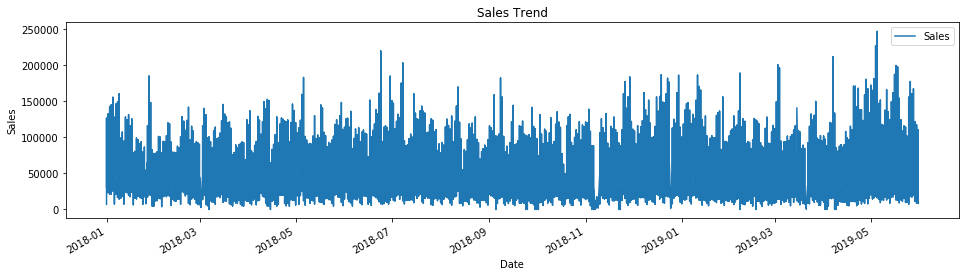

In [199]:
# LET'S CHECK THE TREND OF SALES FOR THE ENTIRE TRAINING PERIOD. 
train.loc[:,['Date','Sales']].plot(x='Date',y='Sales',title='Sales Trend',figsize=(16,4));
plt.ylabel("Sales");

We can observe that there is actually no trend here, it is neither increasing nor decreasing. It is almost constant with slight ups and downs. We may have to expand on it to get finer details.

We do see that towards the end of the plot, the sales seems to be slightly higher than the rest of the plot.

We can also expand the time series and see the sales by year, month quarter etc to get the finer details.

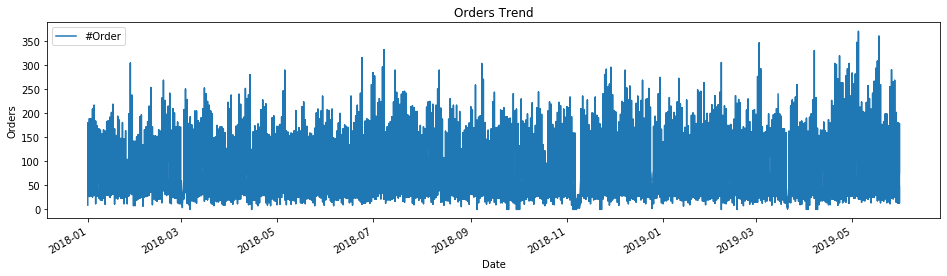

In [200]:
# LET'S CHECK THE TREND OF ORDERS FOR THE ENTIRE TRAINING PERIOD. 
train.loc[:,['Date','#Order']].plot(x='Date',y='#Order',title='Orders Trend',figsize=(16,4));
plt.ylabel("Orders");

We can see that the number of orders received follows the same graph as the sales.

We can also observe that during tht Nov-Dec of 2018 there is a sudden dip in the Sales as well as the orders. We have to explore this further.

In [201]:
train[(train['Date'] > '2018-11-01')&(train['Date'] < '2018-11-15')&(train['#Order']<10)]

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
112104,T1112105,67,S2,L5,R1,2018-11-04,0,No,9,5196.00
112564,T1112565,39,S4,L1,R1,2018-11-05,0,No,0,0.00
112853,T1112854,39,S4,L1,R1,2018-11-06,1,No,0,0.00
113150,T1113151,281,S1,L4,R1,2018-11-07,1,No,8,4386.15
113152,T1113153,321,S3,L1,R2,2018-11-07,1,No,8,4906.44
...,...,...,...,...,...,...,...,...,...,...
114238,T1114239,326,S3,L1,R1,2018-11-09,1,No,9,5687.55
114240,T1114241,159,S2,L1,R3,2018-11-09,1,No,6,4417.92
114242,T1114243,314,S1,L1,R2,2018-11-09,1,No,9,5366.55
114243,T1114244,287,S1,L4,R1,2018-11-09,1,No,8,4248.30


We can see above tat there are 691 data points where the orders received were less than 10 during the period of Nov 1 2018 to Nov 15 2018.

We can also see that there are some rows where the orders and sales are both 0. We can delete them. We can see below that there are 19 such rows.

In [202]:
len(train[(train['#Order']==0)&(train['Sales']==0)])

19

In [203]:
# LET'S GENERATE ADDITIONAL FEATURE USING THE DATE VARIABLE.
def generate_datetime_features(df,columns):
    # This function basically generates different datetime features based on its attributes.
    # columns should be a list of columns that are datetime variables. 

    for col in columns:
        df[col+"_Year"] = df[col].dt.year
        df[col+"_Quarter"] = df[col].dt.quarter
        df[col+"_Month"] = df[col].dt.month
        df[col+"_DayOfMonth"] = df[col].dt.day
        df[col+"_DayOfWeek"] = df[col].dt.dayofweek
        df[col+"_Is_Month_Start"] = df[col].dt.is_month_start
        df[col+"_Is_Month_End"] = df[col].dt.is_month_end
        df[col+"_Is_Quarter_Start"] = df[col].dt.is_quarter_start
        df[col+"_Is_Quarter_End"] = df[col].dt.is_quarter_end
        df[col+'_Is_weekend'] = np.where(df[col+"_DayOfWeek"].isin([5,6]),1,0)
    return df

train = generate_datetime_features(train,['Date'])
test  = generate_datetime_features(test,['Date'])

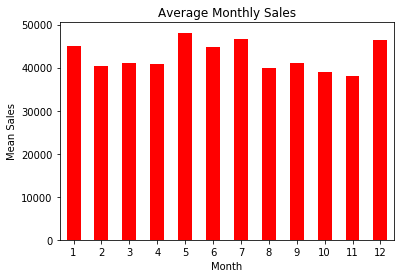

In [204]:
# LET'S CHECK THE SALES ON MONTHLY BASIS
train.groupby('Date_Month')['Sales'].mean().plot(kind='bar',color='red');
plt.title("Average Monthly Sales");
plt.xlabel("Month");
plt.ylabel("Mean Sales");
plt.xticks(rotation=360);

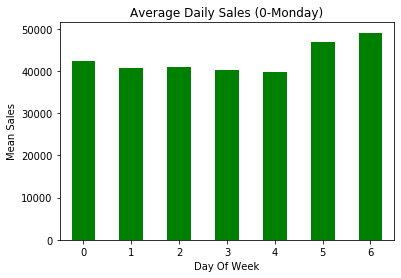

In [205]:
# LET'S CHECK THE SALES ON DAYS OF THE WEEK
train.groupby('Date_DayOfWeek')['Sales'].mean().plot(kind='bar',color='green');
plt.title("Average Daily Sales (0-Monday)");
plt.xlabel("Day Of Week");
plt.ylabel("Mean Sales");
plt.xticks(rotation=360);

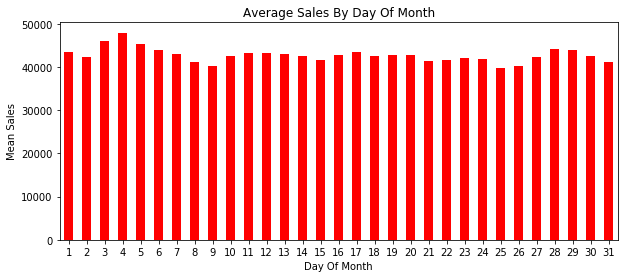

In [206]:
# LET'S CHECK THE SALES ON DAY OF MONTH
train.groupby('Date_DayOfMonth')['Sales'].mean().plot(kind='bar',color='red',figsize=(10,4));
plt.title("Average Sales By Day Of Month");
plt.xlabel("Day Of Month");
plt.ylabel("Mean Sales");
plt.xticks(rotation=360);

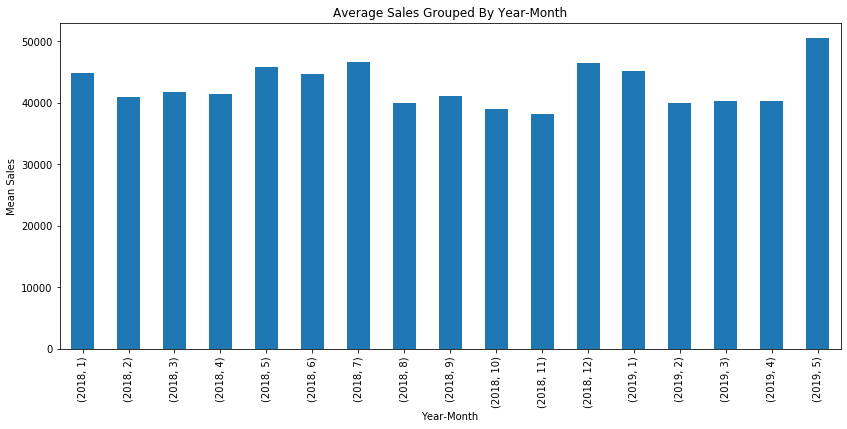

In [207]:
# LET'S CHECK THE SALES GROUPED BY YEAR-MONTH
train.groupby(['Date_Year','Date_Month'])['Sales'].mean().plot(kind='bar',figsize=(14,6));
plt.title("Average Sales Grouped By Year-Month");
plt.xlabel("Year-Month");
plt.ylabel("Mean Sales");
plt.xticks(rotation=90);

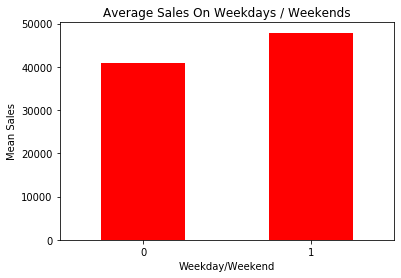

In [208]:
# LET'S CHECK THE SALES ON WEEKDAYS / WEEKENDS
train.groupby('Date_Is_weekend')['Sales'].mean().plot(kind='bar',color='red');
plt.title('Average Sales On Weekdays / Weekends');
plt.xlabel("Weekday/Weekend");
plt.ylabel("Mean Sales");
plt.xticks(rotation=360);

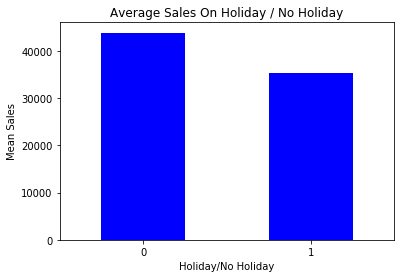

In [209]:
# LET'S CHECK THE SALES WHEN THERE IS A HOLIDAY
train.groupby('Holiday')['Sales'].mean().plot(kind='bar',color='blue');
plt.title('Average Sales On Holiday / No Holiday');
plt.xlabel("Holiday/No Holiday");
plt.ylabel("Mean Sales");
plt.xticks(rotation=360);

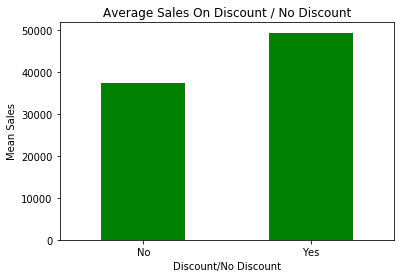

In [210]:
# LET'S CHECK THE SALES WHEN THERE IS A DISCOUNT
train.groupby('Discount')['Sales'].mean().plot(kind='bar',color='green');
plt.title('Average Sales On Discount / No Discount');
plt.xlabel("Discount/No Discount");
plt.ylabel("Mean Sales");
plt.xticks(rotation=360);

We can observe the following from the few plots above,

1. Sales are higher during the months of January, May-July, December, but during the other months it is lower and it remains almost the same.
2. Sales are higher on Saturdays and Sundays, on te other days it is almost constant. 
3. We do not observe any significant pattern in the Day of the month plot. Although the sales are higher on the 4th Day of each month. This is surprising because it is neither at the beginning of the month or at the end (Thses are the pay days).
4. 2019 May had the highest average sales compared to the other months. 
5. Like we had observed earlier, the sales are higher in January, May-July and December of 2018 and January, May of 2019. 
6. We can see that the average sales is slightly higher during the weekends as compared to weekdays.
7. We can see that the average sales are lower when there is a holiday as compared to other days. This may be because people prefer to stay at home during the holidays.
8. We can observe that the sales are higher when there is a discount as compared to no discount days.

### Correlation

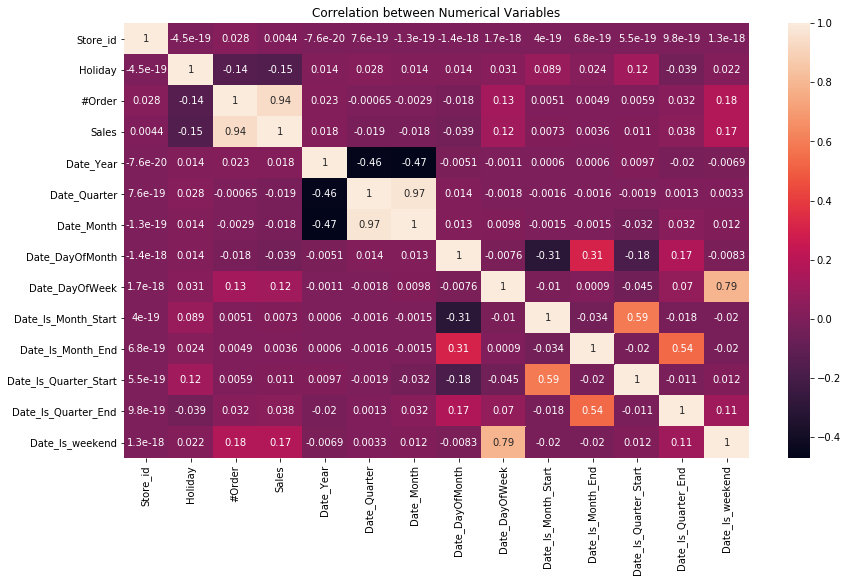

In [211]:
plt.figure(figsize=(14, 8));
plt.title("Correlation between Numerical Variables");
_ = sns.heatmap(train.corr(), annot=True)

### Feature Engineering

In [212]:
# DELETING THE ROWS WHERE BOTH ORDERS AND SALES ARE 0
train.drop(train[(train['#Order']==0)&(train['Sales']==0)].index,axis=0,inplace=True)

In [213]:
# CONCATENATING HOLIDAY AND DISCOUNT VARIABLES
train['Holiday_Discount'] = str(train['Holiday'])+"_"+train['Discount']
test['Holiday_Discount'] = str(test['Holiday'])+"_"+test['Discount']

train['Store_Type_Location_Type'] = train['Store_Type']+"_"+train['Location_Type']
test['Store_Type_Location_Type'] = test['Store_Type']+"_"+test['Location_Type']

train['Region_Code_Location_Type'] = train['Region_Code']+"_"+train['Location_Type']
test['Region_Code_Location_Type'] = test['Region_Code']+"_"+test['Location_Type']

In [214]:
# GENERATING GROUPBY FEATURES
train['Unique_Store_id_Per_Store_Type'] = train.groupby('Store_Type')['Store_id'].transform('nunique')
train['Unique_Store_id_Per_Location_Type'] = train.groupby('Location_Type')['Store_id'].transform('nunique')
train['Unique_Store_id_Per_Region_Code'] = train.groupby('Region_Code')['Store_id'].transform('nunique')
train['Unique_Store_Type_Per_Location_Type'] = train.groupby('Location_Type')['Store_Type'].transform('nunique')
train['Unique_Store_Type_Per_Region_Code'] = train.groupby('Region_Code')['Store_Type'].transform('nunique')


test['Unique_Store_id_Per_Store_Type'] = test.groupby('Store_Type')['Store_id'].transform('nunique')
test['Unique_Store_id_Per_Location_Type'] = test.groupby('Location_Type')['Store_id'].transform('nunique')
test['Unique_Store_id_Per_Region_Code'] = test.groupby('Region_Code')['Store_id'].transform('nunique')
test['Unique_Store_Type_Per_Location_Type'] = test.groupby('Location_Type')['Store_Type'].transform('nunique')
test['Unique_Store_Type_Per_Region_Code'] = test.groupby('Region_Code')['Store_Type'].transform('nunique')

In [215]:
# DELETING THE Date_Year COLUMN AS IT HAS ONLY TWO UNIQUE VALUES IN TRAIN AND 1 UNIQUE VALUE IN TEST DATASETS.
train.drop("Date_Year",axis=1,inplace=True)
test.drop("Date_Year",axis=1,inplace=True)

In [216]:
# LABEL ENCODING THE CATEGORICAL COLUMNS
label_encoder = LabelEncoder()

def label_encoding(df,columns):
    '''This function basically generates label encoded features of cateorical columns.
    columns should be a list of columns that are categorical variables. '''
    
    for col in columns:
        df[col] = label_encoder.fit_transform(df[col])
    
    return df

train = label_encoding(train,['Store_Type','Location_Type','Region_Code','Discount','Holiday_Discount','Store_Type_Location_Type','Region_Code_Location_Type'])
test  = label_encoding(test,['Store_Type','Location_Type','Region_Code','Discount','Holiday_Discount','Store_Type_Location_Type','Region_Code_Location_Type'])

In [217]:
# DROPPING UNNECESSARY COLUMNS
train.drop(['ID','#Order'],axis=1,inplace=True)
test.drop(['ID','Date'],axis=1,inplace=True)

In [218]:
# SORTING THE DATASETS FOR ORDERING OF COLUMNS.
train.sort_index(axis=1, inplace=True)
test.sort_index(axis=1,inplace=True)

In [219]:
# TRAINING AND VALIDATION DATASETS.
training_data=train[train['Date']<'2019-04-01']
validation_data=train[train['Date']>='2019-04-01'] 

In [220]:
# CREATING TRAINING AND VALIDATION SETS
x_train=training_data.drop(columns={'Date','Sales'},axis=1)
y_train=training_data.loc[:,['Sales']]

x_val=validation_data.drop(columns={'Date','Sales'},axis=1)
y_val=validation_data.loc[:,['Sales']]

In [221]:
print (x_train.shape)
print (y_train.shape)
print (x_val.shape)
print (y_val.shape)

(166060, 23)
(166060, 1)
(22261, 23)
(22261, 1)


In [223]:
# MODEL BUILDING
model = xgb.XGBRegressor(
    max_depth=8,
    booster = "gbtree",
    n_estimators=10000, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.01,
    seed=42,
    reg_alpha=1,
    reg_lambda=1,
    objective='reg:squarederror',
    n_jobs=-1)

model.fit(
    x_train, 
    y_train, 
    eval_metric="rmsle", 
    eval_set=[(x_train, y_train), (x_val, y_val)], 
    verbose=True, 
    early_stopping_rounds = 100)

[0]	validation_0-rmsle:4.57682	validation_1-rmsle:4.66737
Multiple eval metrics have been passed: 'validation_1-rmsle' will be used for early stopping.

Will train until validation_1-rmsle hasn't improved in 100 rounds.
[1]	validation_0-rmsle:3.89098	validation_1-rmsle:3.99333
[2]	validation_0-rmsle:3.49259	validation_1-rmsle:3.59989
[3]	validation_0-rmsle:3.20889	validation_1-rmsle:3.31021
[4]	validation_0-rmsle:2.99001	validation_1-rmsle:3.08162
[5]	validation_0-rmsle:2.81311	validation_1-rmsle:2.89892
[6]	validation_0-rmsle:2.66508	validation_1-rmsle:2.75323
[7]	validation_0-rmsle:2.53736	validation_1-rmsle:2.62411
[8]	validation_0-rmsle:2.42519	validation_1-rmsle:2.50899
[9]	validation_0-rmsle:2.32566	validation_1-rmsle:2.41031
[10]	validation_0-rmsle:2.23611	validation_1-rmsle:2.32160
[11]	validation_0-rmsle:2.15307	validation_1-rmsle:2.23496
[12]	validation_0-rmsle:2.07883	validation_1-rmsle:2.16044
[13]	validation_0-rmsle:2.01006	validation_1-rmsle:2.08990
[14]	validation_0-rmsl

[136]	validation_0-rmsle:0.36228	validation_1-rmsle:0.43984
[137]	validation_0-rmsle:0.35975	validation_1-rmsle:0.43734
[138]	validation_0-rmsle:0.35731	validation_1-rmsle:0.43498
[139]	validation_0-rmsle:0.35486	validation_1-rmsle:0.43266
[140]	validation_0-rmsle:0.35241	validation_1-rmsle:0.43015
[141]	validation_0-rmsle:0.35001	validation_1-rmsle:0.42769
[142]	validation_0-rmsle:0.34770	validation_1-rmsle:0.42543
[143]	validation_0-rmsle:0.34561	validation_1-rmsle:0.42293
[144]	validation_0-rmsle:0.34340	validation_1-rmsle:0.42070
[145]	validation_0-rmsle:0.34120	validation_1-rmsle:0.41853
[146]	validation_0-rmsle:0.33905	validation_1-rmsle:0.41647
[147]	validation_0-rmsle:0.33714	validation_1-rmsle:0.41418
[148]	validation_0-rmsle:0.33501	validation_1-rmsle:0.41198
[149]	validation_0-rmsle:0.33310	validation_1-rmsle:0.40990
[150]	validation_0-rmsle:0.33108	validation_1-rmsle:0.40781
[151]	validation_0-rmsle:0.32911	validation_1-rmsle:0.40580
[152]	validation_0-rmsle:0.32718	validat

[273]	validation_0-rmsle:0.23712	validation_1-rmsle:0.29912
[274]	validation_0-rmsle:0.23678	validation_1-rmsle:0.29879
[275]	validation_0-rmsle:0.23651	validation_1-rmsle:0.29847
[276]	validation_0-rmsle:0.23630	validation_1-rmsle:0.29816
[277]	validation_0-rmsle:0.23617	validation_1-rmsle:0.29784
[278]	validation_0-rmsle:0.23595	validation_1-rmsle:0.29756
[279]	validation_0-rmsle:0.23569	validation_1-rmsle:0.29724
[280]	validation_0-rmsle:0.23558	validation_1-rmsle:0.29695
[281]	validation_0-rmsle:0.23528	validation_1-rmsle:0.29670
[282]	validation_0-rmsle:0.23513	validation_1-rmsle:0.29644
[283]	validation_0-rmsle:0.23501	validation_1-rmsle:0.29615
[284]	validation_0-rmsle:0.23481	validation_1-rmsle:0.29584
[285]	validation_0-rmsle:0.23470	validation_1-rmsle:0.29555
[286]	validation_0-rmsle:0.23439	validation_1-rmsle:0.29536
[287]	validation_0-rmsle:0.23416	validation_1-rmsle:0.29514
[288]	validation_0-rmsle:0.23390	validation_1-rmsle:0.29489
[289]	validation_0-rmsle:0.23355	validat

[410]	validation_0-rmsle:0.21880	validation_1-rmsle:0.27962
[411]	validation_0-rmsle:0.21878	validation_1-rmsle:0.27956
[412]	validation_0-rmsle:0.21848	validation_1-rmsle:0.27954
[413]	validation_0-rmsle:0.21812	validation_1-rmsle:0.27970
[414]	validation_0-rmsle:0.21789	validation_1-rmsle:0.27967
[415]	validation_0-rmsle:0.21779	validation_1-rmsle:0.27963
[416]	validation_0-rmsle:0.21763	validation_1-rmsle:0.27958
[417]	validation_0-rmsle:0.21760	validation_1-rmsle:0.27953
[418]	validation_0-rmsle:0.21756	validation_1-rmsle:0.27947
[419]	validation_0-rmsle:0.21735	validation_1-rmsle:0.27940
[420]	validation_0-rmsle:0.21716	validation_1-rmsle:0.27930
[421]	validation_0-rmsle:0.21696	validation_1-rmsle:0.27923
[422]	validation_0-rmsle:0.21692	validation_1-rmsle:0.27919
[423]	validation_0-rmsle:0.21659	validation_1-rmsle:0.27915
[424]	validation_0-rmsle:0.21635	validation_1-rmsle:0.27909
[425]	validation_0-rmsle:0.21633	validation_1-rmsle:0.27902
[426]	validation_0-rmsle:0.21630	validat

[547]	validation_0-rmsle:0.20480	validation_1-rmsle:0.27674
[548]	validation_0-rmsle:0.20459	validation_1-rmsle:0.27672
[549]	validation_0-rmsle:0.20452	validation_1-rmsle:0.27671
[550]	validation_0-rmsle:0.20451	validation_1-rmsle:0.27670
[551]	validation_0-rmsle:0.20448	validation_1-rmsle:0.27670
[552]	validation_0-rmsle:0.20428	validation_1-rmsle:0.27680
[553]	validation_0-rmsle:0.20425	validation_1-rmsle:0.27678
[554]	validation_0-rmsle:0.20423	validation_1-rmsle:0.27676
[555]	validation_0-rmsle:0.20422	validation_1-rmsle:0.27675
[556]	validation_0-rmsle:0.20400	validation_1-rmsle:0.27670
[557]	validation_0-rmsle:0.20397	validation_1-rmsle:0.27669
[558]	validation_0-rmsle:0.20382	validation_1-rmsle:0.27671
[559]	validation_0-rmsle:0.20372	validation_1-rmsle:0.27671
[560]	validation_0-rmsle:0.20371	validation_1-rmsle:0.27670
[561]	validation_0-rmsle:0.20359	validation_1-rmsle:0.27673
[562]	validation_0-rmsle:0.20354	validation_1-rmsle:0.27670
[563]	validation_0-rmsle:0.20350	validat

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.01, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.00999999978, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=-1, num_parallel_tree=1,
             random_state=42, reg_alpha=1, reg_lambda=1, scale_pos_weight=1,
             seed=42, subsample=0.8, tree_method=None,
             validate_parameters=False, verbosity=None)

In [224]:
#PREDICTING ON VALIDATION DATA
pred=model.predict(x_val)

In [225]:
# EVALUATION METRIC FOR VALIDATION DATA
(mean_squared_log_error(y_val,pred))*1000

76.55600587440037

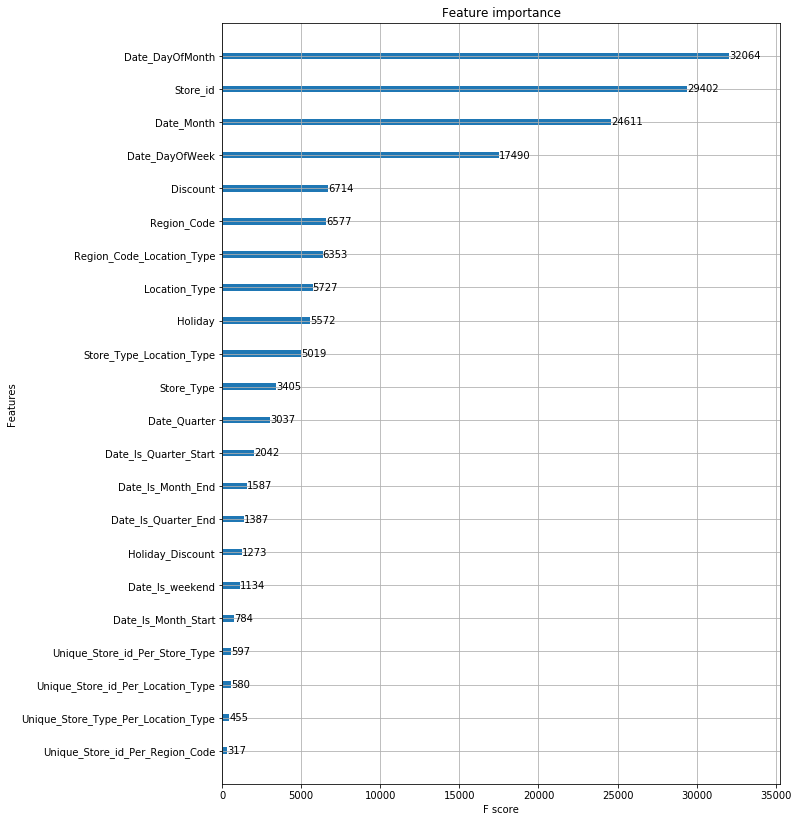

In [226]:
# PLOTTING FEATURE IMPORTANCES
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
plot_features(model, (10,14))

In [227]:
# PREDICTING ON THE TESTING DATASET AND CREATING SUBMISSION FILE
Submission['Sales'] = model.predict(test)
Submission.to_csv(r"C:\Users\kulka\Desktop\AV_Hackathon_Codes\Jobathon_Sep\Submissions\Submission_25.csv",index=None)

C:\Users\kulka\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [228]:
Submission.head()

,ID,Sales
0,T1188341,61034.945312
1,T1188342,39314.050781
2,T1188343,77672.632812
3,T1188344,40455.503906
4,T1188345,41040.785156


In [ ]:
# Public LB Score: 208.277653270504